In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1, 1, 28, 28)
x.shape

torch.Size([1, 1, 28, 28])

In [12]:
x = F.relu(conv1(x))

In [13]:
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
x = F.max_pool2d(x, 2, 2)

In [15]:
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
x = F.relu(conv2(x))

In [17]:
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
x.view(-1, 16 * 5 * 5).shape

torch.Size([1, 400])

In [21]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 5 * 5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
import time
start_time = time.time()


epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# Run the training batches
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

epoch:  0  batch:  600 [  6000/60000]  loss: 0.24575421  accuracy:  78.450%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.65931159  accuracy:  85.700%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01969394  accuracy:  88.794%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02576473  accuracy:  90.542%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01212707  accuracy:  91.660%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00760453  accuracy:  92.483%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.07230872  accuracy:  93.062%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00292655  accuracy:  93.594%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00042489  accuracy:  94.004%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00450279  accuracy:  94.350%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01885824  accuracy:  98.000%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.34362853  accuracy:  97.892%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.39755189  accuracy:  97.861%
epoch:  1  b

### Plot the loss and accuracy comparisons

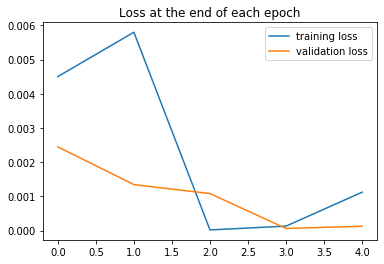

In [28]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

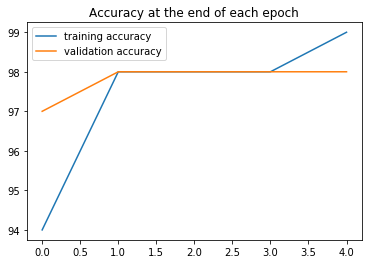

In [29]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Evaluate Test Data

In [30]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9852/10000 =  98.520%


### Display the confusion matrix

In [32]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 980    0    6    0    0    3    6    3   11    3]
 [   0 1130    7    0    0    0    1    2    0    1]
 [   0    0 1007    1    0    0    0    4    0    0]
 [   0    1    1 1006    0    9    0    1    1    1]
 [   0    0    1    0  980    0    2    0    1   10]
 [   0    2    0    1    0  862    1    0    2    2]
 [   0    0    0    0    1    1  944    0    0    1]
 [   0    0    9    0    0    1    0 1010    1    4]
 [   0    2    1    2    0    6    4    2  957   11]
 [   0    0    0    0    1   10    0    6    1  976]]
